In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
from PIL import Image
from sklearn.utils import shuffle
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Data Exploration

In [2]:
# download dataset
# reference: https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/
# NOTE: Need to upload kaggle.json file manually if it does not exist in Files (Google Colab)

!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download ashishjangra27/face-mask-12k-images-dataset
!unzip face-mask-12k-images-dataset.zip

In [ ]:
#!kaggle datasets list

In [3]:
# check how many images and their sizes

# obtain paths
test_mask_path = './Face Mask Dataset/Test/WithMask'
test_nomask_path = './Face Mask Dataset/Test/WithoutMask'
train_mask_path = './Face Mask Dataset/Train/WithMask'
train_nomask_path = './Face Mask Dataset/Train/WithoutMask'
val_mask_path ='./Face Mask Dataset/Validation/WithMask'
val_nomask_path = './Face Mask Dataset/Validation/WithoutMask'

# os.listdir gets all files in a given path
image_count = 0
image_sizes = set()
paths_list = [test_mask_path, test_nomask_path, train_mask_path, train_nomask_path, val_mask_path, val_nomask_path]

#function to add width and height to image_sizes set
#and returns the number of images
def checkImages(path, image_sizes):
  count = 0
  for i in os.listdir(path):
    count += 1
    im = Image.open(os.path.abspath(path + "/" + i))
    width, height = im.size
    image_sizes.add((width, height))
  return count

for path in paths_list:
  image_count += checkImages(path, image_sizes)

#image_count = len(list(data_dir.glob('*/*.jpg')))
print("Total images:", image_count)
print("Image sizes (Width, Height):", image_sizes)

Total images: 11792
Image sizes (Width, Height): {(53, 53), (45, 45), (58, 58), (133, 133), (123, 123), (66, 66), (50, 50), (129, 129), (127, 127), (90, 90), (38, 38), (89, 89), (39, 39), (179, 179), (35, 35), (101, 101), (27, 27), (155, 155), (93, 93), (74, 74), (28, 28), (36, 36), (119, 119), (137, 137), (330, 330), (42, 42), (284, 284), (82, 82), (98, 98), (30, 30), (46, 46), (158, 158), (338, 338), (31, 31), (97, 97), (81, 81), (47, 47), (224, 224), (32, 32), (107, 107), (115, 115), (141, 141), (71, 71), (121, 121), (135, 135), (120, 120), (125, 125), (131, 131), (67, 67), (124, 124), (132, 132), (95, 95), (126, 126), (130, 130), (113, 113), (79, 79), (143, 143), (128, 128), (112, 112), (25, 25), (29, 29), (37, 37), (118, 118), (138, 138), (105, 105), (87, 87), (151, 151), (104, 104), (136, 136), (33, 33), (109, 109), (83, 83), (117, 117), (147, 147), (139, 139), (75, 75), (148, 148), (116, 116), (108, 108), (70, 70), (140, 140), (56, 56), (69, 69), (59, 59), (307, 307), (60, 60), 

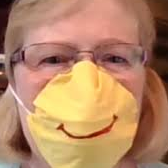

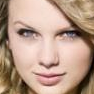

In [4]:
# view some example images
mask_im = Image.open(os.path.abspath(test_mask_path + "/1174.png"))
nomask_im = Image.open(os.path.abspath(test_nomask_path + "/3006.png"))
display(mask_im)
display(nomask_im)

In [6]:
# class names
class_names = ['Masked', 'Not masked']
print(class_names)

['Masked', 'Not masked']


In [7]:
from tensorflow.keras.preprocessing.image import img_to_array

def SetUpData(mask_path):
  mask_list = []
  mask_labels = []
  for i in os.listdir(mask_path):
    im = Image.open(os.path.abspath(mask_path + "/" + i))
    width, height = im.size
    if width >= 100 and height >= 100:
      im = im.resize((100, 100))
      # convert to numpy array
      im = img_to_array(im)
      mask_list.append(im)

      append_label_value = -1
      if 'WithoutMask' in mask_path:
        append_label_value = 0
      else:
        append_label_value = 1
      # -1 means error
      #1 for mask
      #0 for no mask
      mask_labels.append(append_label_value)
  return mask_list, mask_labels


# set up data for training mask data
# establish dataframe containing masked images and their targets
train_mask_df = pd.DataFrame()
train_mask_df['image'], train_mask_df['target'] = SetUpData(train_mask_path)


# set up data for training nonmask data
# establish dataframe containing nonmasked images and their targets
train_nomask_df = pd.DataFrame()
train_nomask_df['image'], train_nomask_df['target'] = SetUpData(train_nomask_path)


# combine separate training dataframes and shuffle
train_df = pd.concat([train_mask_df, train_nomask_df])
train_df = shuffle(train_df)


# set up data for testing mask data
# establish dataframe containing masked images and their targets
test_mask_df = pd.DataFrame()
test_mask_df['image'], test_mask_df['target'] = SetUpData(test_mask_path)


# set up data for testing nomask data
# establish dataframe containing nonmasked images and their targets
test_nomask_df = pd.DataFrame()
test_nomask_df['image'], test_nomask_df['target'] = SetUpData(test_nomask_path)


# combine separate testing dataframes and shuffle
test_df = pd.concat([test_mask_df, test_nomask_df])
test_df = shuffle(test_df)

In [8]:
train_df

,image,target
3519,"[[[223.0, 217.0, 215.0], [223.0, 217.0, 215.0]...",1
2475,"[[[160.0, 58.0, 54.0], [167.0, 53.0, 52.0], [1...",0
1867,"[[[60.0, 42.0, 33.0], [60.0, 42.0, 33.0], [60....",1
1348,"[[[242.0, 244.0, 229.0], [242.0, 244.0, 229.0]...",1
1086,"[[[34.0, 34.0, 21.0], [34.0, 34.0, 20.0], [34....",1
...,...,...
1314,"[[[253.0, 250.0, 246.0], [222.0, 214.0, 213.0]...",1
2854,"[[[232.0, 215.0, 198.0], [228.0, 212.0, 196.0]...",0
465,"[[[170.0, 209.0, 130.0], [172.0, 211.0, 132.0]...",0
473,"[[[107.0, 85.0, 61.0], [108.0, 85.0, 60.0], [1...",1


In [9]:
test_df

,image,target
147,"[[[35.0, 20.0, 23.0], [37.0, 22.0, 25.0], [40....",0
41,"[[[164.0, 102.0, 47.0], [166.0, 103.0, 49.0], ...",1
325,"[[[253.0, 253.0, 249.0], [252.0, 251.0, 247.0]...",0
357,"[[[33.0, 23.0, 21.0], [35.0, 26.0, 21.0], [36....",0
104,"[[[38.0, 31.0, 23.0], [41.0, 34.0, 26.0], [61....",0
...,...,...
107,"[[[15.0, 12.0, 7.0], [12.0, 9.0, 4.0], [5.0, 2...",0
65,"[[[105.0, 89.0, 89.0], [105.0, 89.0, 89.0], [1...",0
27,"[[[43.0, 39.0, 38.0], [14.0, 10.0, 9.0], [9.0,...",0
28,"[[[30.0, 13.0, 13.0], [24.0, 9.0, 9.0], [23.0,...",1


In [10]:
# creating the model
train_model = Sequential([
  layers.Rescaling(1./255, input_shape=(100, 100, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid'),
])

In [11]:
# compiling the model
train_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [12]:
train_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        1

In [13]:
train_image_array = np.stack(np.asarray(train_df["image"]))
test_image_array = np.stack(np.asarray(test_df["image"]))
train_target_array = np.asarray(train_df["target"])
test_target_array = np.asarray(test_df["target"])

In [14]:
print(train_image_array.shape)

(8020, 100, 100, 3)


In [15]:
fitted_Model = train_model.fit(train_image_array, train_target_array, validation_split=0.15, batch_size=10, epochs=10)

Epoch 1/10
682/682 [==============================] - 77s 112ms/step - loss: 0.1100 - accuracy: 0.9557 - val_loss: 0.0505 - val_accuracy: 0.9751
Epoch 2/10
682/682 [==============================] - 77s 112ms/step - loss: 0.0422 - accuracy: 0.9847 - val_loss: 0.0312 - val_accuracy: 0.9900
Epoch 3/10
682/682 [==============================] - 76s 111ms/step - loss: 0.0341 - accuracy: 0.9880 - val_loss: 0.0283 - val_accuracy: 0.9875
Epoch 4/10
682/682 [==============================] - 78s 115ms/step - loss: 0.0247 - accuracy: 0.9908 - val_loss: 0.0346 - val_accuracy: 0.9892
Epoch 5/10
682/682 [==============================] - 76s 111ms/step - loss: 0.0163 - accuracy: 0.9937 - val_loss: 0.0324 - val_accuracy: 0.9900
Epoch 6/10
682/682 [==============================] - 75s 110ms/step - loss: 0.0177 - accuracy: 0.9944 - val_loss: 0.0372 - val_accuracy: 0.9909
Epoch 7/10
682/682 [==============================] - 76s 111ms/step - loss: 0.0153 - accuracy: 0.9946 - val_loss: 0.0547 - val_ac

In [16]:
## evaluate model to compare training vs. test error
from sklearn.metrics import classification_report

yhat_train = train_model.predict(train_image_array)
yhat_train = [1 if y>=0.5 else 0 for y in yhat_train]
yhat_test = train_model.predict(test_image_array)
yhat_test = [1 if y>=0.5 else 0 for y in yhat_test]

print("Training performance:\n %s" % classification_report(train_target_array, yhat_train))

print("Testing performance:\n %s" % classification_report(test_target_array, yhat_test))


25/25 [==============================] - 2s 88ms/step
Training performance:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3611
           1       1.00      1.00      1.00      4409

    accuracy                           1.00      8020
   macro avg       1.00      1.00      1.00      8020
weighted avg       1.00      1.00      1.00      8020

Testing performance:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       372
           1       1.00      0.99      0.99       427

    accuracy                           0.99       799
   macro avg       0.99      0.99      0.99       799
weighted avg       0.99      0.99      0.99       799



25/25 [==============================] - 2s 87ms/step - loss: 0.0371 - accuracy: 0.9937


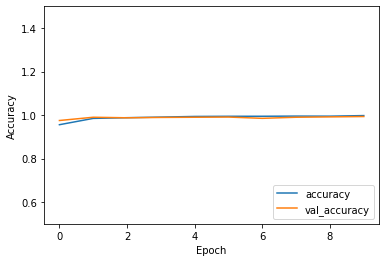

In [18]:
# Evaluation Graph
import matplotlib.pyplot as plt

plt.plot(fitted_Model.history['accuracy'], label='accuracy')
plt.plot(fitted_Model.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.5])
plt.legend(loc='lower right')

test_loss, test_acc = train_model.evaluate(test_image_array, test_target_array)

In [ ]:
# Fitting Graph
# should show test not val_accuracy

# do model.evaluate() on your test
#tensorflow -> make more models https://www.tensorflow.org/tutorials/keras/classification https://www.tensorflow.org/tutorials/images/classification